In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

import pdb

In [2]:
def fit_ssd(data, ssd_info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    #freqs_sig = 5, 8  # theta
    #freqs_noise = 4, 9  # theta
    freqs_sig = 9, 14  # alpha
    freqs_noise = 8, 15  # alpha
    #freqs_sig = 15, 29  # beta
    #freqs_noise = 14, 30  # beta
    # freqs_sig = 35, 45  # gamma
    # freqs_noise = 30, 50  # gamma

    ssd = SSD(info=ssd_info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    ssd.fit(X=data)
    return ssd


def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def spatio_spectral_shift(epochs_pre_post, epochs_info):
    
    n_comp = 3
    
    epochs_pre = epochs_pre_post[0]
    epochs_post = epochs_pre_post[1]
    epochs_agg = np.concatenate(epochs_pre_post, axis=0)
    
    ssd_patterns_all = list()
    for epochs in [epochs_pre, epochs_post]:
        ssd = fit_ssd(epochs, epochs_info)
        # get top n_comp components
        ssd_patterns = ssd.patterns_[:n_comp]
        # normalize each vector independently
        ssd_patterns /= np.linalg.norm(ssd_patterns, axis=1, keepdims=True)
        ssd_patterns_all.append(ssd_patterns)
    
    A = np.linalg.pinv(ssd_patterns_all[0]).T @ ssd_patterns_all[1].T
    
    
    # compute stats across pre/post sessions
    ssd_std_diff = ssd_patterns_all[1].std() - ssd_patterns_all[0].std()
    ssd_patterns_diff = ssd_patterns_all[1] - ssd_patterns_all[0]
    #ssd_patterns_diff_flip = ssd_patterns[1] + ssd_patterns[0]
    # note that some subjects have sessions where the spatial SSD pattern
    # remains consistent, but with opposite sign
    # given that an opposite sign of an SSD weight reflects a pi-radians phase
    # difference, here I explored the possibility that the sign assigned to a
    # given SSD vector is somewhat arbitrary by taking the SSD weight
    # difference with minimal magnitude
    #ssd_norm = min(np.sqrt(np.mean(ssd_patterns_diff ** 2)),
    #               np.sqrt(np.mean(ssd_patterns_diff_flip ** 2)))
    ssd_patterns_diff = (A @ ssd_patterns_all[0]) - ssd_patterns_all[1]
    ssd_norm = np.mean(np.sqrt(np.sum(ssd_patterns_diff ** 2, axis=1)))  # mean of the norms
    #ssd_norm = np.mean(np.sqrt(np.sum(A ** 2)))
    return ssd_std_diff, ssd_norm


def spec_event_coherence_shift(epochs_pre_post, times):
    # set path to SpectralEvents
    sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
    import spectralevents as se
    
    #event_band = [5, 8]  # theta band (Hz)
    #event_band = [15, 29]  # beta band (Hz)
    event_band = [9, 14]  # alpha band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    time_bin = 0.05  # 50 ms; try 25 ms for beta 
    binned_times = np.arange(0, times[-1] + time_bin, time_bin)
    n_bins = len(binned_times)
    
    pre_post_coherence = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        event_raster = list()
        for chan_idx in range(n_chans):
            chan_events = np.zeros((n_epochs, n_bins))  # to store binary event flags
            chan_epochs_data = epochs_data[:, chan_idx, :].squeeze()
            
            # compute TFRs
            tfrs = se.tfr(chan_epochs_data, freqs, samp_freq)
            # find events
            spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                         event_band=event_band, threshold_FOM=6.)
            
            n_events = [len(epoch_events) for epoch_events in spec_events]
            print(f'Found {sum(n_events)} spectral events in current channel.')
            for epoch_idx, epoch_events in enumerate(spec_events):
                for event in epoch_events:
                    bin_idx = np.nonzero(binned_times > event['Peak Time'])[0][0]
                    chan_events[epoch_idx, bin_idx] = 1
            event_raster.append(chan_events)
            
            # sanity check: plot event_raster
            #plt.figure()
            #plt.pcolormesh(binned_times, np.arange(n_epochs), chan_events)
            
        event_intersection = event_raster[0] * event_raster[1]
        event_union = ((event_raster[0] + event_raster[1]) > 0).astype(int)
        sess_coherence = event_intersection.mean() / event_union.mean()
        
        print(f'Mean inter-hemisphere beta event coherence for current session: {sess_coherence}!!!')
        pre_post_coherence.append(sess_coherence)
    
    return pre_post_coherence[1] - pre_post_coherence[0]


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    epochs_pre_post, epochs_info, _ = read_data(subj_id, series_num, data_dir)
    ssd_std_diff, ssd_norm = spatio_spectral_shift(epochs_pre_post, epochs_info)
    
    epochs_pre_post_c3_c4, _, times = read_data(subj_id, series_num, data_dir, pick_channels=['C3', 'C4'])
    spec_event_coherence_diff = spec_event_coherence_shift(epochs_pre_post_c3_c4, times)
    
    return ssd_std_diff, ssd_norm, spec_event_coherence_diff


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.median(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.median(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [3]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [4]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_subj_series = sum(subj_select)

In [5]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
symptoms_init = outcome_info['IDSSRtot.Ses1'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

## start test pipeline
--------------------

In [7]:
data_type_dir = op.join(data_dir, data_type)
epochs_pre_post, epochs_info, _ = read_data(subj_ids[0], series_nums[0], data_type_dir)
ssd_weights = list()
for sess_idx, epochs_data in enumerate(epochs_pre_post):
    ssd = fit_ssd(epochs_data, epochs_info)
    ssd_weights.append(ssd)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_44222/598795927.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_44222/598795927.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished


    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished


    Using tolerance 6.1e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


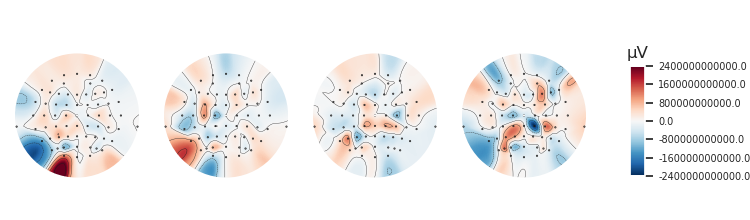

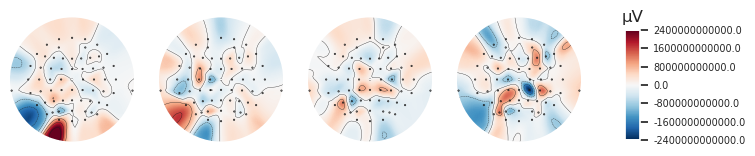

In [8]:
pattern = mne.EvokedArray(data=ssd.filters_[:, :4],
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

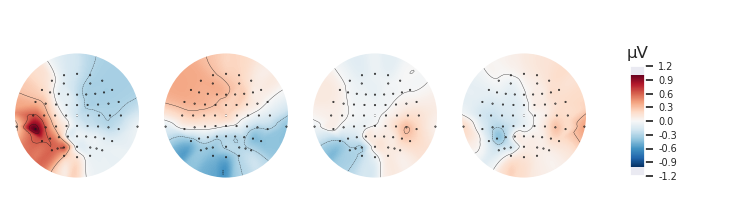

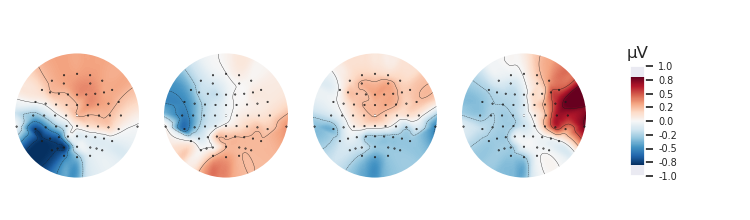

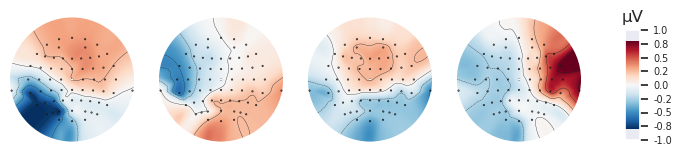

In [9]:
pattern = mne.EvokedArray(data=ssd_weights[0].patterns_[:4].T,
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

pattern = mne.EvokedArray(data=ssd_weights[1].patterns_[:4].T,
                          info=epochs_info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

In [34]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
ssd_std_diff, ssd_norm, spec_event_coherence_diff = get_features(subj_ids[0], series_nums[0], data_type_dir)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_37627/3193549151.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_37627/3193549151.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 4.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 9.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 9.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.6s finished


    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Setting up band-pass filter from 5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 4.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 4 - 9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 9.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 9.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished


    Using tolerance 2.7e-12 (2.2e-16 eps * 64 dim * 1.9e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_37627/3193549151.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_37627/3193549151.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 228 spectral events in current channel.
Found 203 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.07142857142857142!!!
Found 210 spectral events in current channel.
Found 209 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06578947368421052!!!


## end test pipeline
------------------------------

In [6]:
# run spatio-spectral and cross-hemisphere beta coherence features
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 24
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_subj_series))
ssd_std_diffs, ssd_norms, spec_event_coherence_diffs = zip(*out)

# convert to numpy arrays
ssd_std_diffs = np.array(ssd_std_diffs)
ssd_norms = np.array(ssd_norms)
spec_event_coherence_diffs = np.array(spec_event_coherence_diffs)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Not setting metadata
75 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
80 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0246_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Read

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0296_Post_Session1_Series2_Preprocessed.set...
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
Not setting metadata
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
74 matching events found
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0293_Post_Session1_Series2_Preprocessed.set...
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0261_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
87 matching events found
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0296_Post_Session1_Series3_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
121

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- F

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
    Using tolerance 1.9e-11 (2.2e-16 eps * 64 dim * 1.4e+03  max singular value)
    Using tolerance 4.1e-12 (2.2e-16 eps * 64 dim * 2.9e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Done.
Reducing data rank from 64 -> 64
    Using tolerance 5.1e-12 (2.2e-16 eps * 64 dim * 3.6e+02  max singular value)
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Computing rank from data with ra

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.5e+02  max singular value)
    Using tolerance 6.1e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 3.1e-12 (2.2e-16 eps * 64 dim * 2.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

Done.
Reducing data rank from 64 -> 64
    Using tolerance 3.5e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
Done.
Estimating covariance using OAS
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 4.4e-12 (2.2e-16 eps * 64 dim * 3.1e+02  max singular value)
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, ze

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-12 (2.2e-16 eps * 64 dim * 3.9e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting 

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Done.
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-11 (2.2e-16 eps * 64 dim * 1.2e+03  max singular value)
Done.
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 8 - 15 Hz

FI

Reducing data rank from 64 -> 64
Not setting metadata
56 matching events found
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0302_Post_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0267_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found
Not setting metadata
62 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1e-11 (2.2e-16 eps * 64 dim * 7.2e+02  max singular value)
Computing rank from data with rank=None
    Estimated r

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0291_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 1.6e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
No baseline correction applied
No baseline correction applied
0 projection items activated
0 projection items activated
Ready.
Ready.
Not setting metadata
95 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0305_Post_Session1_Series1_Preprocessed.set...
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0291_Post_Session1_Series1_Preprocessed.set...
Ready.
Not setting metadata
58 matching events found

Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 114 spectral events in current channel.
Found 99 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.019801980198019806!!!
Found 113 spectral events in current channel.
Found 127 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.036036036036036036!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0313_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
82 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0310_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from 

No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0330_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
Effective window size : 1.000 (s)
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using 

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 153 spectral events in current channel.
Found 143 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06015037593984962!!!
Found 148 spectral events in current channel.
Found 163 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06093189964157706!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0346_Pre_Session1_Series1_Prepr

Effective window size : 1.000 (s)
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0352_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

    Using tolerance 2e-11 (2.2e-16 eps * 64 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.4e-11 (2.2e-16 eps * 64 dim * 1e+03  max singular value)
    Using tolerance 6.5e-12 (2.2e-16 eps * 64 dim * 4.6e+02  max singular value)
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamm

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Not setting metadata
102 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0357_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1e-12 (2.2e-16 eps * 64 dim * 71  max singular value)
Not setting metadata
123 matching events found
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0361_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Not setting metadata
79 matching events found
Ready.
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items ac

Not setting metadata
97 matching events found
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0364_Post_Session1_Series2_Preprocessed.set...
    Using tolerance 6.4e-12 (2.2e-16 eps * 64 dim * 4.5e+02  max singular value)
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass


    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.7e-11 (2.2e-16 eps * 64 dim * 1.9e+03  max singular value)
Done.
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0305_Pre_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0336_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
79 matching events found
    Using tolerance 9.7e-12 (2.2e-16 eps * 64 dim * 6.8e+02  max singular value)
Reducing data rank from 64 -> 64
Done.
    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0336_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Not setting metadata
42 matching events found
    Estimated rank (eeg

No baseline correction applied
0 projection items activated
Reducing data rank from 64 -> 64
Ready.
Done.
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0313_Post_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
81 matching events found
Done.
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 2.9e-11 (2.2e-16 eps * 64 dim * 2.1e+03  max singular value)
Estimating covariance using OAS
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0370_Post_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
105 matching events found
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
No baseline correction applied
0 projection items activated
Ready.
Done.
Done.
Found 140 spectral events in current channel.
Found 128 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.015325670498084292!!!
Found 70 spectral events in current channel.
Found 78 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03676470588235294!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0370_Pre_Session1_Series2_Preprocessed.set...
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal b

Computing rank from data with rank=None
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Computing rank from data with rank=None
Done.
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0332_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
93 matching events found
Found 92 spectral events in current channel.
Found 89 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.029411764705882353!!!

Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0348_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
94 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
    Using tolerance 3.7e-12 (2.2e-16 eps * 6

    Using tolerance 8.8e-12 (2.2e-16 eps * 64 dim * 6.2e+02  max singular value)
    Using tolerance 3.7e-12 (2.2e-16 eps * 64 dim * 2.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 8 - 15 Hz

FIR filter paramete

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Done.
Estimating covariance using OAS
Not setting metadata
85 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Done.
Found 162 spectral events in current channel.
Found 148 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03424657534246575!!!
Found 253 spectral events in current channel.
Found 260 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.032854209445585224!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0378_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0356_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Found 215 spectral events in current channel.
Found 214 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.035443037974683546!!!
Found 195 spectral events in current channel.
Found 201 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.043010752688172046!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0379_Pre_Session1_Series1_Preprocessed.set...
Estimating covariance using OAS
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.8e+02  max singular value)
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/ser

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6080 out of 6080 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0364_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
84 matching events found
Found 91 spectral events in current channel.
Found 138 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03240740740740741!!!
Found 98 spectral events in current channel.
Found 121 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01941747572815534!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0380_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gp

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Done.
Estimating covariance using OAS
Effective window size : 1.000 (s)
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0389_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.5e-11 (2.2e-16 eps * 64 dim * 1.8e+03  max singular value)
Computing rank from data with rank=None
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Found 178 spectral events in current channel.
Found 166 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.030487804878048783!!!
Found 199 spectral events in current channel.
Found 172 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.017241379310344827!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0390_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Done.
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0390_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pa

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0367_Pre_Session1_Series1_Preprocessed.set...
Done.
Done.
Not setting metadata
92 matching events found
Computing rank from data with rank=None
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0357_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
116 matching events found
    Using tolerance 1.6e-11 (2.2e-16 eps * 64 dim * 1.2e+03  max singular value)
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0367_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
88 matching events found
    Using tolerance 3e-11 (2.2e-16 eps * 64 dim * 2.1e+03  max singular value)
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5696 out of 5696 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0373_Post_Session1_Series2_Preprocessed.set...
    Using tolerance 4.6e-12 (2.2e-16 eps * 64 dim * 3.3e+02  max singular value)
Not setting metadata
87 matching events found
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.2e-11 (2.2e-16 eps * 64 dim * 8.4e+02  max singular value)
Done.
Setting up band-pass filter from 

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Effective window size : 1.000 (s)
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 8.1e+02  max singular value)
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 9.6e-12 (2.2e-16 eps * 64 dim * 6.7e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG:

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4352 out of 4352 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Found 273 spectral events in current channel.
Found 286 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02268431001890359!!!
Found 315 spectral events in current channel.
Found 342 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0436241610738255!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0415_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Estimating covariance using OAS
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0415_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 9 -

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Found 92 spectral events in current channel.
Found 81 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.037037037037037035!!!
Found 187 spectral events in current channel.
Found 145 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.015723270440251572!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0416_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
83 matching events found
Estimating covariance using OAS
Effective window size : 1.000 (s)
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0416_Post_Session1_Series1_Prepr

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
101 matching events found
Not setting metadata
105 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0419_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
    Using tolerance 1.6e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
Ready.
Reducing data rank from 64 -> 64
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 133 spectral events in current channel.
Found 145 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.022813688212927757!!!
Found 131 spectral events in current channel.
Found 112 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03879310344827586!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0420_Pre_Session1_Series1_Prep

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 7e-12 (2.2e-16 eps * 64 dim * 4.9e+02  max singular value)
    Using tolerance 4.5e-12 (2.2e-16 eps * 64 dim * 3.2e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0376_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 7.5e-12 (2.2e-16 eps * 64 dim * 5.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper tr

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
    Using tolerance 5.2e-12 (2.2e-16 eps * 64 dim * 3.7e+02  max singular value)
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Extracting parameters from /gpfs/da

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
86 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0365_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
113 matching events found
Reducing data rank from 64 -> 64
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.6e+02  max singular value)
Computing rank from data with rank=None
Estimating covariance using OAS
    Using tolerance 1.3e-11 (2.2e-16 eps * 64 dim * 9.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
------------------

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6592 out of 6592 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.1e-11 (2.2e-16 eps * 64 dim * 1.5e+03  max singular value)
Done.
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
    Using tolerance 2.6e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Done.
Effective window size : 1.000 (s)
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Computing rank from data with rank=None
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0409_Pre_Session1_Series1_Preprocessed.set...
    Using tolerance 1.7e-11 (2.2e-16 eps * 64 dim * 1.2e+03  max singular value)
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0409_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
26 matching events found
    Using tolerance 6.2e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
98 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Using tolerance 2.6e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Effective window size : 1.000 (s)
    Using tolerance 3.1e-11 (2.2e-16 eps * 64 dim * 2.2e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0392_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 216 spectral events in current channel.
Found 216 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06377551020408163!!!
Found 179 spectral events in current channel.
Found 179 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.055045871559633024!!

Not setting metadata
81 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) meth

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7488 out of 7488 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Done.
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6336 out of 6336 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
81 matching events found
Found 128 spectral events in current channel.
Found 128 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.020833333333333336!!!
Found 89 spectral events in current channel.
Found 126 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.009569377990430623!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0461_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
Not setting metadata
92 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0451_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
76 matching events found
No baseline correction applie

Reducing data rank from 64 -> 64
Not setting metadata
89 matching events found
Done.
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
No baseline correction applied
0 projection items activated
Ready.
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0415_Post_Session1_Series1_Preprocessed.set...
Effective window size : 1.000 (s)
Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Not setting metadata
78 matching events found
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Effective window size : 1.00

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0420_Pre_Session1_Series1_Preprocessed.set...
Done.
Computing rank from data with rank=None
Not setting metadata
78 matching events found
Computing rank from data with rank=None
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0420_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transitio

Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2.4e-11 (2.2e-16 eps * 64 dim * 1.7e+03  max singular value)
    Using tolerance 3.2e-12 (2.2e-16 eps * 64 dim * 2.3e

Computing rank from data with rank=None
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
    Using tolerance 6.8e-12 (2.2e-16 eps * 64 dim * 4.8e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0419_Pre_Session1_Series2_Preprocessed.set...
Estimating covariance using OAS
Done.
Not setting metadata
115 matching events found
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
    Using tolerance 1e-11 (2.2e-16 eps * 64 dim * 7.3e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0419_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
    Estimated rank (eeg): 64
    EEG: r

Ready.
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 4e-12 (2.2e-16 eps * 64 dim * 2.8e+02  max singular value)
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge:

/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_46599/591537951.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5952 out of 5952 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T2/preprocessed/9001_Post_Session1_Series6_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0437_Pre_Session1_Series1_Prepr

Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0467_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
83 matching events found
Not setting metadata
81 matching events found
Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Effective wi

Not setting metadata
87 matching events found
Reducing data rank from 64 -> 64
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2.6e-11 (2.2e-16 eps * 64 dim * 1.8e+03  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0472_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0472_Post_Session1_Series1_Preproces

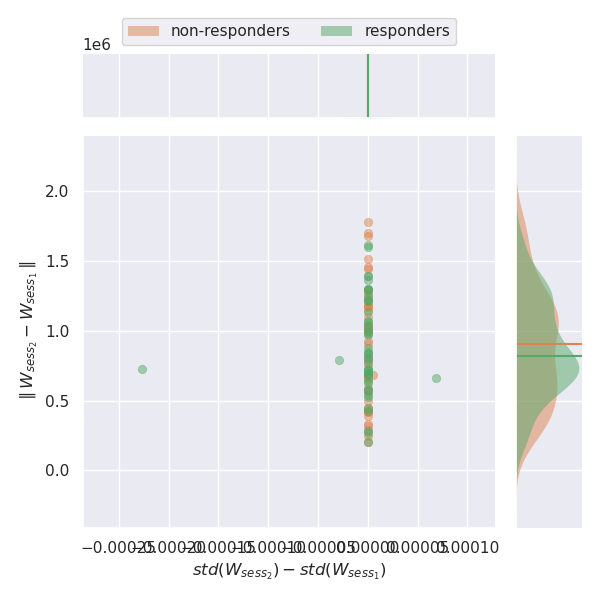

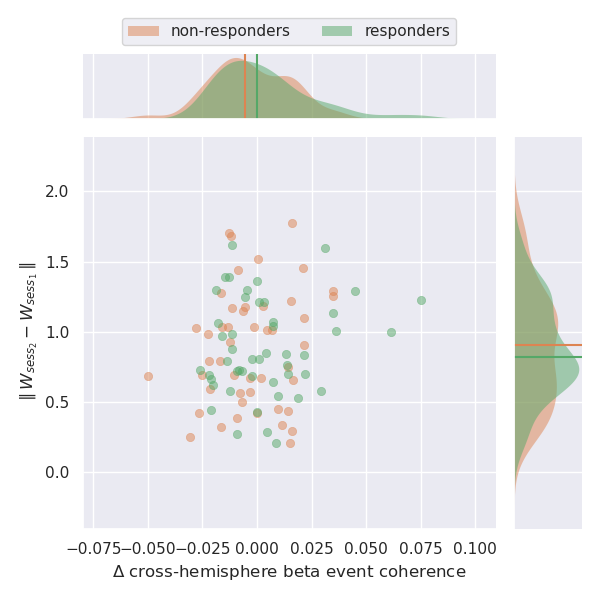

In [7]:
# plot 1st and 2nd features
ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=ssd_std_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
plot_features_scatter(x=spec_event_coherence_diffs, y=ssd_norms, responder_labels=responders, ax_labels=ax_labels)

In [15]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = np.c_[ssd_norms, ssd_std_diffs, spec_event_coherence_diffs]
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)

In [16]:
X = np.c_[ssd_norms, ssd_std_diffs, spec_event_coherence_diffs, ages, sexes, depression_histories, symptoms_init]
X = StandardScaler().fit_transform(X)
svm_cls = svm.SVC(kernel='rbf')
svm_cls.fit(X, responders)
svm_cls.score(X, responders)

0.7684210526315789

In [9]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(0.7 * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.5051379310344828


In [10]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(0.7 * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ssd_norms[train_idxs],
                    ssd_std_diffs[train_idxs],
                    spec_event_coherence_diffs[train_idxs],
                    ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ssd_norms[test_idxs],
                   ssd_std_diffs[test_idxs],
                   spec_event_coherence_diffs[test_idxs],
                   ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.4516896551724138


In [11]:
ssd_norms

array([2.17027906, 2.03006286, 0.83793233, 1.19770282, 2.04153891,
       0.49447932, 1.16779984, 2.28473618, 1.32303334, 2.33088382,
       1.75309326, 0.36568013, 0.58046732, 2.9801976 , 3.11471895,
       2.32206288, 2.03374052, 2.28654121, 1.45693321, 1.50977294,
       1.40253336, 3.04271864, 1.96665404, 2.45051444, 0.95763924,
       1.73543353, 1.85316156, 1.13419828, 2.43806645, 1.33144642,
       1.14715885, 1.02417525, 1.833368  , 2.26013678, 1.99720512,
       1.21525051, 2.19404246, 2.58942303, 3.23892032, 1.81334046,
       2.10587023, 0.62893829, 0.77272801, 2.06792778, 2.06212927,
       1.6675244 , 0.49533961, 2.68405956, 1.33915247, 2.23011815,
       0.50789776, 1.0723892 , 1.04538515, 1.64717782, 1.27512133,
       0.46581378, 1.40132619, 1.6005119 , 2.49771416, 1.84050339,
       2.28553114, 1.76905345, 1.25343002, 1.76735214, 0.38167098,
       1.86791211, 1.30889966, 1.22340026, 2.4774356 , 0.76795907,
       0.99043671, 0.9725188 , 1.33401962, 0.74487663, 1.29592

Found 46 spectral events in current channel.
Found 26 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0!!!
Found 40 spectral events in current channel.
Found 35 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 100 spectral events in current channel.
Found 102 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.015384615384615384!!!
Found 80 spectral events in current channel.
Found 73 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03424657534246575!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 227 spectral events in current channel.
Found 173 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.018617021276595747!!!
Found 137 spectral events in current channel.
Found 137 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.01556420233463035!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4544 out of 4544 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 124 spectral events in current channel.
Found 102 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03255813953488372!!!
Found 115 spectral events in current channel.
Found 86 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02577319587628866!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5248 out of 5248 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 150 spectral events in current channel.
Found 157 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0704225352112676!!!
Found 157 spectral events in current channel.
Found 179 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0438871473354232!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6336 out of 6336 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 100 spectral events in current channel.
Found 140 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.02586206896551724!!!
Found 58 spectral events in current channel.
Found 125 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.011049723756906077!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 193 spectral events in current channel.
Found 175 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.05637982195845698!!!
Found 180 spectral events in current channel.
Found 180 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03550295857988166!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 135 spectral events in current channel.
Found 134 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03278688524590164!!!
Found 193 spectral events in current channel.
Found 224 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06199460916442048!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4416 out of 4416 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 97 spectral events in current channel.
Found 141 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.012987012987012988!!!
Found 109 spectral events in current channel.
Found 96 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0049261083743842365!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 174 spectral events in current channel.
Found 185 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.032448377581120944!!!
Found 165 spectral events in current channel.
Found 176 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.046583850931677016!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6720 out of 6720 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 136 spectral events in current channel.
Found 78 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.024630541871921183!!!
Found 226 spectral events in current channel.
Found 228 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.055825242718446605!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6272 out of 6272 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 211 spectral events in current channel.
Found 176 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.040760869565217385!!!
Found 191 spectral events in current channel.
Found 205 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.031746031746031744!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 255 spectral events in current channel.
Found 283 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.09183673469387756!!!
Found 121 spectral events in current channel.
Found 141 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.06557377049180328!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 89 spectral events in current channel.
Found 91 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.017142857142857144!!!
Found 48 spectral events in current channel.
Found 53 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1664 out of 1664 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 129 spectral events in current channel.
Found 156 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03461538461538462!!!
Found 174 spectral events in current channel.
Found 158 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.012738853503184712!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6784 out of 6784 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 152 spectral events in current channel.
Found 171 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.043478260869565216!!!
Found 120 spectral events in current channel.
Found 171 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.029629629629629627!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 7104 out of 7104 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 68 spectral events in current channel.
Found 80 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.006896551724137931!!!
Found 216 spectral events in current channel.
Found 235 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.08208955223880597!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 154 spectral events in current channel.
Found 161 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03389830508474576!!!
Found 108 spectral events in current channel.
Found 132 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.00851063829787234!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 150 spectral events in current channel.
Found 145 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04255319148936171!!!
Found 86 spectral events in current channel.
Found 91 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.023809523809523808!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4288 out of 4288 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 88 spectral events in current channel.
Found 103 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.010582010582010581!!!
Found 63 spectral events in current channel.
Found 60 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.008196721311475409!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5312 out of 5312 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 128 spectral events in current channel.
Found 140 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0311284046692607!!!
Found 66 spectral events in current channel.
Found 92 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.04666666666666666!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5568 out of 5568 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 47 spectral events in current channel.
Found 65 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.009090909090909092!!!
Found 24 spectral events in current channel.
Found 32 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.0!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 273 spectral events in current channel.
Found 268 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.039603960396039604!!!
Found 148 spectral events in current channel.
Found 185 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.028391167192429023!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6400 out of 6400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]:

Found 85 spectral events in current channel.
Found 105 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.05172413793103449!!!
Found 81 spectral events in current channel.
Found 97 spectral events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.03550295857988166!!!


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_45058/4278082975.py:39: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: